# New York Stock Exchange Data Analysis

## Import the libraries

In [21]:
import time
import seaborn
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)
plt.style.use('ggplot')

%matplotlib inline

## Data preprocessing

We will laod the data and process it to transform in the desired format which is more sutaible for the data analysis. Once we transorm the data we will write it to the disk so that we can directly read the data from the file next time rather thamn going through the data processing again


<b>The dataset has been taken from kaggle<b>
https://www.kaggle.com/dgawlik/nyse/downloads/nyse.zip

#### Read the dataset

In [5]:
prices=pd.read_csv("prices-split-adjusted.csv");
print(prices.shape)

(851264, 7)


### Lets take a look on the dataset

In [6]:
prices.sample(frac=0.1).head()

,date,symbol,open,close,low,high,volume
344547,2012-11-30,CLX,75.370003,76.349998,74.750000,76.459999,3722400.0
755159,2016-03-30,NLSN,52.529999,52.799999,52.320000,52.840000,1672200.0
836255,2016-11-16,XRX,9.580000,9.550000,9.530000,9.600000,6660000.0
303664,2012-07-26,CNC,18.705000,18.845000,18.524999,18.930001,1961200.0
359550,2013-01-16,SLG,78.790001,79.330002,78.660004,79.389999,324200.0


### Lets see a summary staticstics for the data

In [48]:
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


#### Check if the data contains any missing values

In [42]:
prices.apply(lambda x: sum(x.isnull()),axis=0)

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

The Dataset does not contain any missing values, hence no imputation is required

### Visualize the stock trend for 10 older companies, which has been longer in the stock market

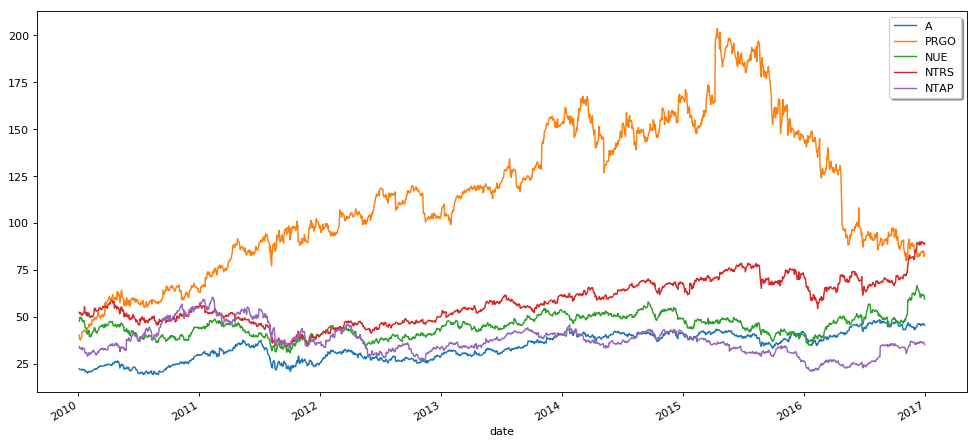

In [5]:
# Processing subset of data
subset_companies=5
data=prices
data['count']=1
companies_data_count=pd.DataFrame(data.groupby("symbol")['count'].count())
companies_data_count.sort_values('count',ascending=False,inplace=True)
older_companies=companies_data_count.iloc[0:subset_companies].index.tolist()

plt.figure(figsize=(15, 7), dpi= 80, facecolor='w', edgecolor='k')
for company in older_companies:
    company_stock=data[data['symbol']==company]
    ts= pd.Series(company_stock['close'].values,index=pd.to_datetime(company_stock['date']))
    ts.plot(label=company,linewidth=1.3);
    
plt.legend(shadow=True, fancybox=True)
#plt.rcParams['figure.figsize'] = (15,15)
plt.figure(figsize=(5,5))

#### Feature derivation

Prepare the matrix from the given data by using the preious 1 month stock price as the feature for predicting a closing stock price for a given company

In [6]:
# If need to process subset of data
subset_companies=150
data=prices
data['count']=1
companies_data_count=pd.DataFrame(data.groupby("symbol")['count'].count())
companies_data_count.sort_values('count',ascending=False,inplace=True)
high_stock_data_count_companies=companies_data_count.iloc[0:subset_companies].index.tolist()
high_stock_data_count_companies

data=data[data.apply(lambda x: x['symbol'] in high_stock_data_count_companies,axis=1)].sort_values('symbol').reset_index(drop=True)
data.drop('count',1,inplace=True)
data=data.sort_values(['symbol','date']).reset_index(drop=True)
data.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,A,22.453504,22.389128,22.267525,22.625180,3815500.0
1,2010-01-05,A,22.324749,22.145923,22.002861,22.331903,4186000.0
2,2010-01-06,A,22.067240,22.067240,22.002861,22.174536,3243700.0
3,2010-01-07,A,22.017168,22.038626,21.816881,22.045780,3095100.0
4,2010-01-08,A,21.917024,22.031474,21.745350,22.067240,3733900.0


In [6]:
# Processing all data
data=prices
data['count']=1
companies_data_count=pd.DataFrame(data.groupby("symbol")['count'].count())
companies_data_count.sort_values('count',ascending=False,inplace=True)
data=data.sort_values('symbol').reset_index(drop=True)
data.drop('count',1,inplace=True)
data=data.sort_values('symbol')
data.shape

(851264, 7)

In [7]:
start_time = time.clock()

#Drop the date column
data=data.drop(["date"],1)

#Define teh stock period which is to be considered as feature for predicting a days closing stock price
relevent_stock_period=22

'''Loop through all the data and create a input data matrix where all the data of relevent_stock_period for 
   each data point is kept as feature 
'''
input_feature_matrix = pd.DataFrame()
numberOfRecords= data.shape[0]

#-1 for the symbol
dataColumns=data.shape[1]-1

#to combine the data and track it
previous_company=''
all_stock_data=[]
all_company_data_count={}

#To keep a track on the counts of toal record, data count for one company
i=0
company_data_counter=0;
total_data_counter=1

## to track data processing progress based on the number of companies the data is procesed for
total_companies=len(data['symbol'].unique().tolist())
companies_processsed=0;
percent_processed=0;
percent_limit=10
while(i<numberOfRecords):
    current_company=data.iloc[i,0]
    #If new company data encounter move i by relevent_stock_period
    if(current_company!=previous_company):
        i=i+relevent_stock_period
        all_company_data={previous_company,company_data_counter}
        company_data_counter=1
        #percentage of data processed
        progress=companies_processsed*100/total_companies;
        if(progress>percent_processed+percent_limit):
            print("Data Processed: "+str(int(progress))+" %\tTime Elapsed: "+str(round(time.clock()-start_time,2))+" seconds")
            percent_processed=percent_processed+percent_limit
        
        companies_processsed+=1
    else:
        company_data_counter+=1
    
    #unroll the features and append to the list
    relevent_stock_period_data=data.iloc[i-relevent_stock_period:i,1:].values.flatten()
    relevent_stock_period_data=np.append(np.append(current_company,relevent_stock_period_data),data.close[i])
    relevent_stock_period_data=np.reshape(relevent_stock_period_data,(1,(relevent_stock_period)*dataColumns+2))
    all_stock_data.append(relevent_stock_period_data)
    previous_company=current_company
    i=i+1

# Check the processing status for completion
progress=companies_processsed*100/total_companies;
print("Data Processed: "+str(int(progress))+" %\tTime Elapsed: "+str(round(time.clock()-start_time,2))+" seconds")

Data Processed: 10 %	Time Elapsed: 18.05 seconds
Data Processed: 20 %	Time Elapsed: 37.17 seconds
Data Processed: 30 %	Time Elapsed: 56.27 seconds
Data Processed: 40 %	Time Elapsed: 81.35 seconds
Data Processed: 50 %	Time Elapsed: 97.24 seconds
Data Processed: 60 %	Time Elapsed: 113.5 seconds
Data Processed: 70 %	Time Elapsed: 128.37 seconds
Data Processed: 80 %	Time Elapsed: 144.32 seconds
Data Processed: 90 %	Time Elapsed: 160.88 seconds
Data Processed: 100 %	Time Elapsed: 177.75 seconds


###### Transform the data into a dataframe

In [8]:
start_time = time.clock()
#create the dataframe
all_stock_data = np.array(all_stock_data)
all_stock_data=np.reshape(all_stock_data,(len(all_stock_data),(relevent_stock_period)*dataColumns+2))

#create the dataframe
input_data_matrix=pd.DataFrame(all_stock_data)

#Assign the column names to the dataframe and rest the index
columns_name=[]
for feature_counter in range(0,input_data_matrix.shape[1]):
    if feature_counter==0:
        name="company"
    elif feature_counter==input_data_matrix.shape[1]-1:
        name="close"
    else:
        name="feature_"+str(feature_counter)
    columns_name.append(name)
    
input_data_matrix.columns=columns_name
input_data_matrix=input_data_matrix.reset_index(drop=True)

print("Data Transormation took "+str(round(time.clock()-start_time,2))+" seconds")

Data Transormation took 19.29 seconds


#### Add polynomial terms in the dataset

In [10]:
start_time=time.clock()
degree_of_polynomial=2

#Seperate the output
output=input_data_matrix['close']
features=input_data_matrix.drop(['close'],1)
features.iloc[:,1:]=features.iloc[:,1:].astype(float)

feature_ploynomial=features
for i in range(2,degree_of_polynomial+1):
    print("Adding degree "+str(i)+" Polynomial Feature...")
    feature_ploynomial=pd.concat([feature_ploynomial,np.power(features.iloc[:,1:],i)],axis=1)
    
#Re-assign the column names to the dataframe
columns_name=[]
for feature_counter in range(0,feature_ploynomial.shape[1]):
    if feature_counter==0:
        name="company"
    else:
        name="feature_"+str(feature_counter)
    columns_name.append(name)
    
input_data_matrix_polynomial=feature_ploynomial
input_data_matrix_polynomial.columns=columns_name

print("Creating "+str(degree_of_polynomial)+" degree polynomial took "+str(round(time.clock()-start_time,2))+" seconds")
input_data_matrix_polynomial['close']=output

input_data_matrix_polynomial.shape

Adding degree 2 Polynomial Feature...
Creating 2 degree polynomial took 24.33 seconds


(261000, 222)

#### Write the data to disk

Since the formating the input data to desired feature matrix is taking long time, hence write the data to a csv file so that we dont have to compute this processing again and we can directly load the data

In [11]:
start_time = time.clock()
input_data_matrix_polynomial.to_csv("data-with-polynomial-features-150-companies.csv",index=False)
print("Writing the data to disk took "+str(round(time.clock()-start_time,2))+" seconds")

Writing the data to disk took 88.23 seconds


### Data Analysis

#### Load the preprocessed dataset from the disk

In [12]:
start_time = time.clock()
input_data_matrix=pd.read_csv("data-with-polynomial-features-150-companies.csv");
print("Reading the data from disk "+str(round(time.clock()-start_time,2))+" seconds")
print(input_data_matrix.shape)

Reading the data from disk 21.46 seconds
(261000, 222)


### Build a predictive model for the given company

##### Check few sample companies

In [13]:
input_data_matrix_polynomial.sample(frac=0.1,random_state=123).head()['company']

47313      LEN
169829    PAYX
220950     TSS
13274      IVZ
260137     VNO
Name: company, dtype: object

In [17]:
#company="PAYX"
company="VNO"
relevent_data=input_data_matrix_polynomial[input_data_matrix_polynomial['company']==company].reset_index(drop=True)

####  Split the input matrix dataset in training and test dataset

We will split the dataset in training and test and then sperated the feature variables from the decison variable

In [18]:
start_time = time.clock()

#Split the training and test data
train_data=relevent_data.sample(frac=0.8,random_state=123).sort_values("company").reset_index(drop=True)
test_data=relevent_data.drop(train_data.index).sort_values("company").reset_index(drop=True)

train_feature=train_data.drop('close',1)
train_output=train_data.close.astype(float)

test_feature=test_data.drop('close',1)
test_output=test_data.close.astype(float)

print(train_feature.shape)
print(test_feature.shape)

print("\nTrain Test Split took "+str(round(time.clock()-start_time,2))+" seconds")

(1392, 221)
(348, 221)

Train Test Split took 0.04 seconds


# Predictive Models

We will build few predictive models and will compare their performnce in order to choose the best model for predicting the stock closing prices

### Simple Ploynomial Regression

In [19]:
lr_model=LinearRegression(normalize=True)
lr_model.fit(train_feature.iloc[:,1:],train_output)
lr_train_prediction=lr_model.predict(train_feature.iloc[:,1:])
lr_mse_train=mean_squared_error(lr_train_prediction,train_output)
print("MSE on training dataset="+str(lr_mse_train))
print("\nNumber of zero coefficient:"+str(len(lr_model.coef_[lr_model.coef_==0])))
print("\nSmallest Coefficient: "+str(np.min(lr_model.coef_))+" \t Largest Coefficient: "+str(np.max(lr_model.coef_)) )

MSE on training dataset=1.02120886887

Number of zero coefficient:0

Smallest Coefficient: -1.66532457887 	 Largest Coefficient: 2.00649151652


#### Check performance using MSE on the test dataset

In [20]:
lr_test_prediction=lr_model.predict(test_feature.iloc[:,1:])
lr_mse_test=mean_squared_error(lr_test_prediction,test_output)
print("Linear Regression Model's MSE on Test data="+str(np.round(lr_mse_test,3)))

Linear Regression Model's MSE on Test data=1.432


#### Build a Ridge Regression Model

In [21]:
subset=train_feature.shape[0]
ridge_model = Ridge(alpha=0.01,random_state=42, normalize=True)
ridge_model.fit(train_feature.iloc[0:subset,1:],train_output.iloc[0:subset])
ridge_train_prediction=ridge_model.predict(train_feature.iloc[0:subset,1:])
ridge_mse_train=mean_squared_error(ridge_train_prediction,train_output)
print("MSE on training dataset="+str(ridge_mse_train))
print("\nNumber of zero coefficient:"+str(len(ridge_model.coef_[ridge_model.coef_==0])))
print("\nSmallest Coefficient: "+str(np.min(ridge_model.coef_))+" \t Largest Coefficient: "+str(np.max(ridge_model.coef_)))

MSE on training dataset=1.30704075024

Number of zero coefficient:0

Smallest Coefficient: -0.0170661518643 	 Largest Coefficient: 0.241267329748


#### check the performance on the test dataset

In [22]:
ridge_test_prediction=ridge_model.predict(test_feature.iloc[:,1:])
ridge_mse_test=mean_squared_error(ridge_test_prediction,test_output)
print("Ridge Regression Model's MSE on Test data="+str(np.round(ridge_mse_test,3)))

Ridge Regression Model's MSE on Test data=1.752


####  Build a lasso regression model

In [23]:
lasso_model=Lasso(alpha=0.01,normalize=True,max_iter=1000)
lasso_model.fit(train_feature.iloc[:,1:],train_output)
lasso_train_prediction=lasso_model.predict(train_feature.iloc[:,1:])
mean_squre_error=mean_squared_error(lasso_train_prediction,train_output)
print("MSE on training dataset="+str(mean_squre_error))
print("zero out coefficient:"+str(len(lasso_model.coef_[lasso_model.coef_==0])))
features=train_feature.iloc[:,1:].columns

print("\nFeatures with non zero-coefficents:"+str(list(features[np.nonzero(lasso_model.coef_)[0]])))
print("\nSmallest Coefficient: "+str(np.min(lasso_model.coef_))+" \t Largest Coefficient: "+str(np.max(lasso_model.coef_)))

MSE on training dataset=1.43875233661
zero out coefficient:215

Features with non zero-coefficents:['feature_81', 'feature_83', 'feature_106', 'feature_107', 'feature_108']

Smallest Coefficient: 0.0 	 Largest Coefficient: 0.936264689999


#### Check the performance on the test dataset

In [24]:
lasso_test_prediction=lasso_model.predict(test_feature.iloc[:,1:])
lasso_mse_test=mean_squared_error(lasso_test_prediction,test_output)
print("Laso Regression Model's MSE on Test data="+str(np.round(lasso_mse_test,3)))

Laso Regression Model's MSE on Test data=1.76


# Model Comparisons:

We will compare the predictions by ploting the predicted and actual value  for each model and then we also check the residual plot for each model which will give us an insight about the distribution of the difference between the actual and predicted values.

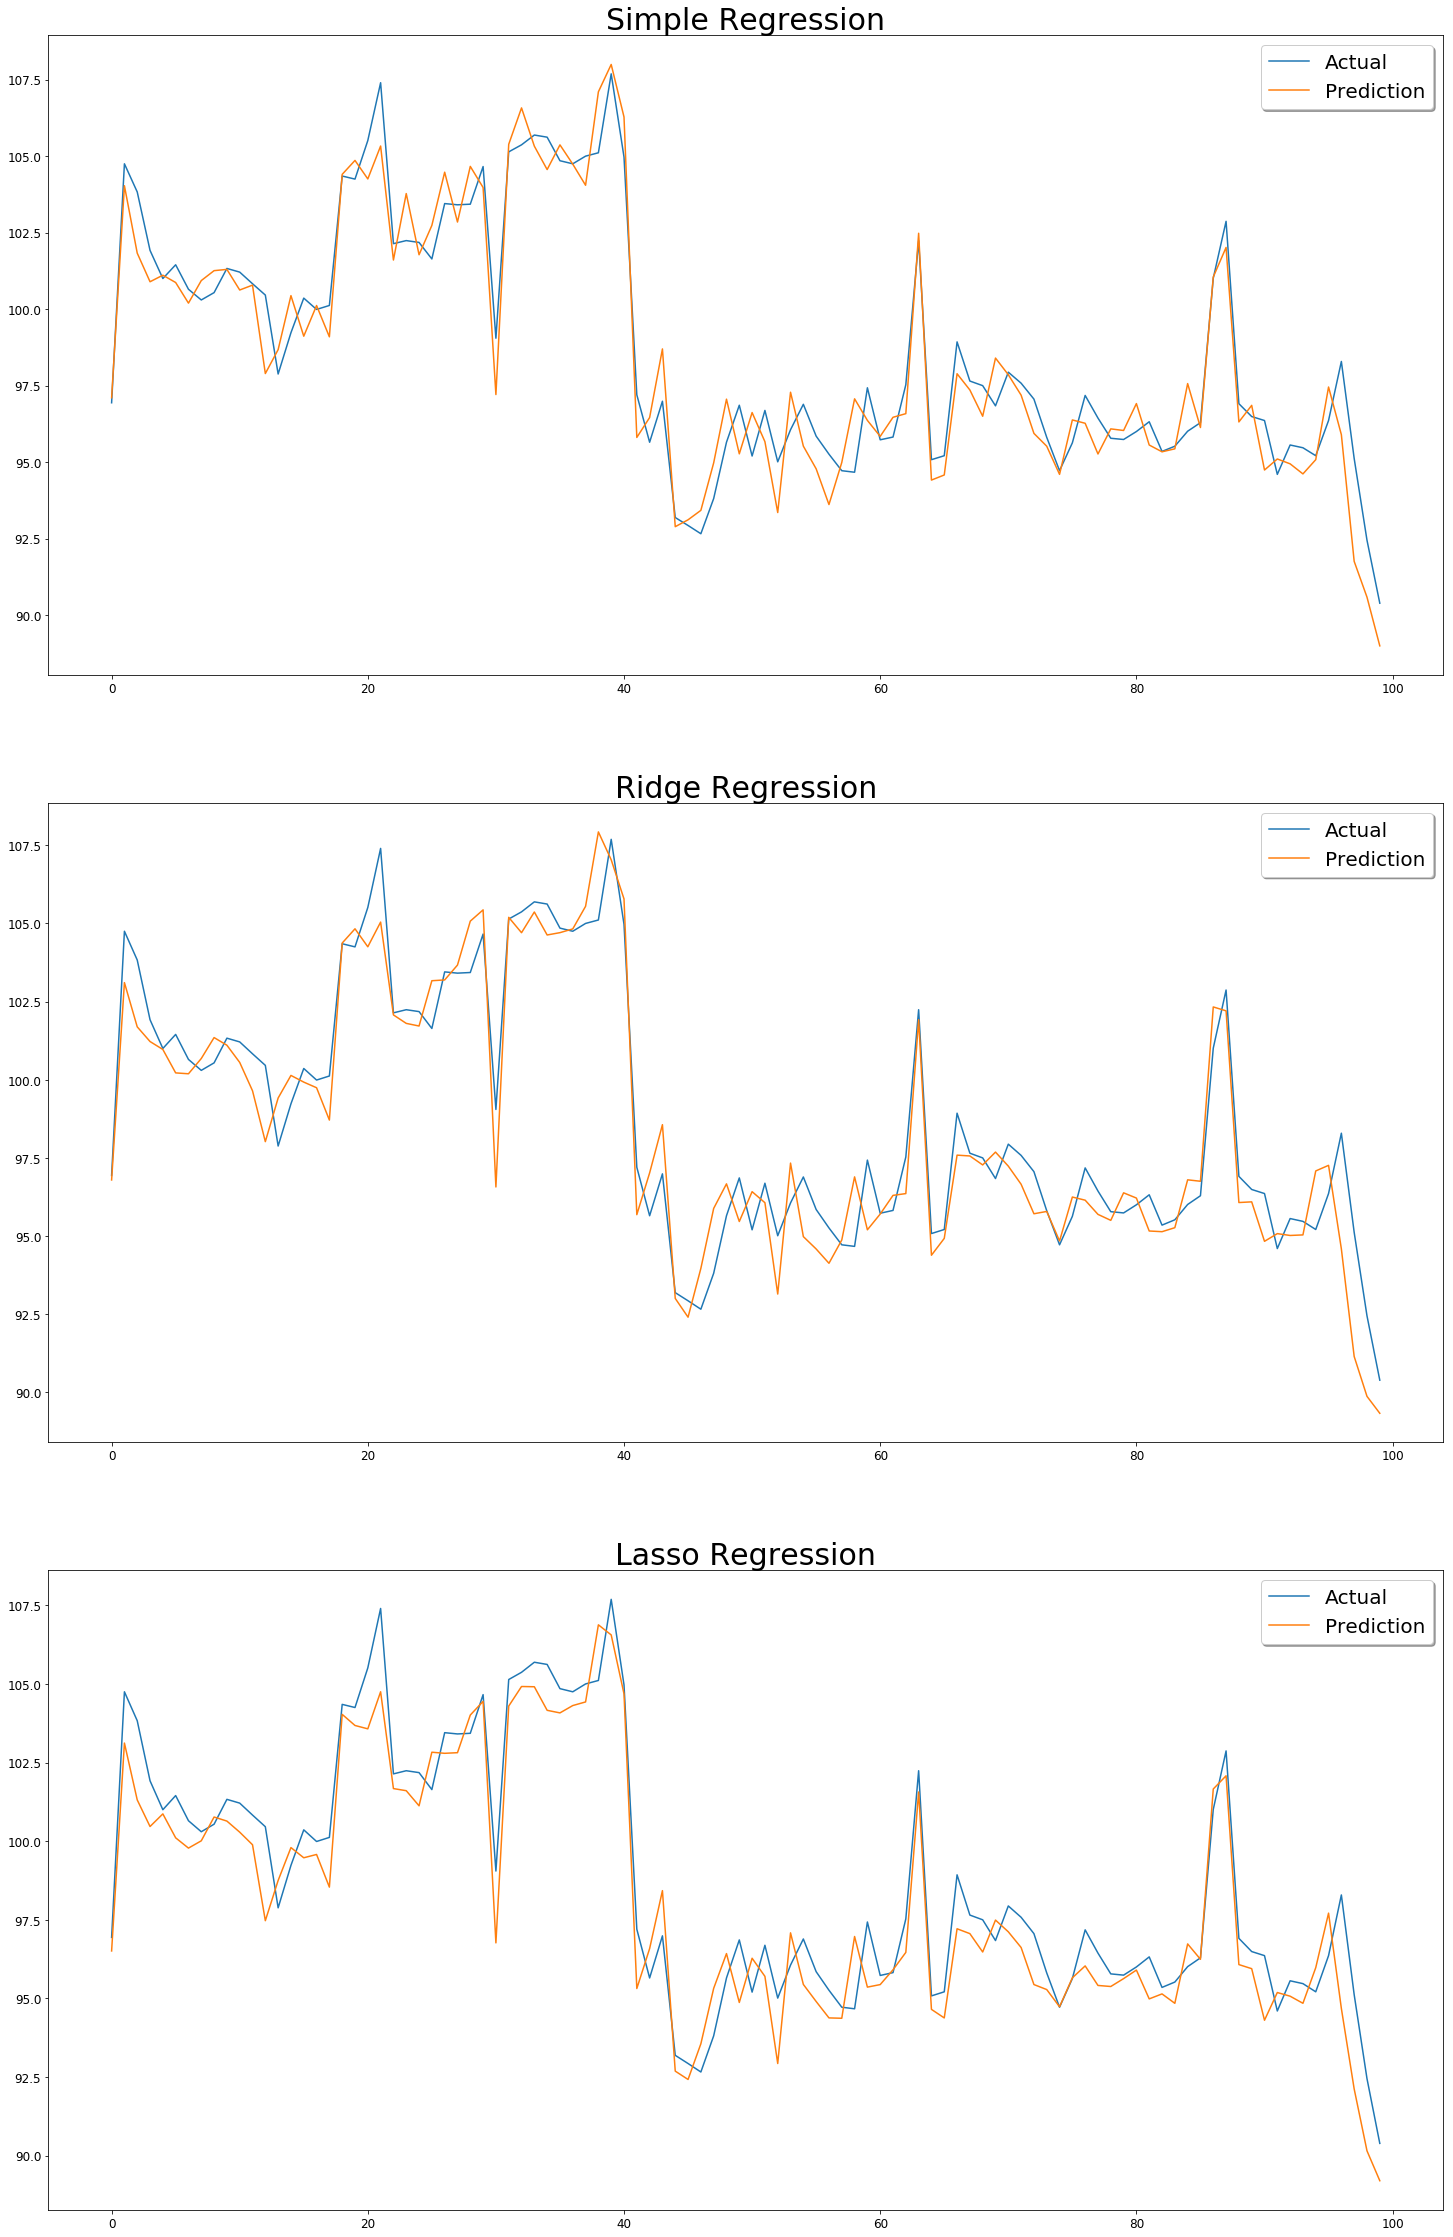

In [32]:
#Choose a sample size, for ploting the data
sample_size=100;

actual_test=pd.DataFrame({"Actual":test_output})
lr_test=pd.DataFrame({"Regression":lr_test_prediction})
ridge_test=pd.DataFrame({"Ridge":ridge_test_prediction})
lasso_test=pd.DataFrame({"Lasso":lasso_test_prediction})
#pd.DataFrame([test_output, lr_test_prediction])

test_comparisons=pd.concat([actual_test,lr_test,ridge_test,lasso_test],axis=1)


sample=test_comparisons[0:sample_size]
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.figure(figsize=(25,40))

plt.subplot(311)
plt.title("Simple Regression",fontsize=30)
plt.plot(sample['Actual'],label="Actual")
plt.plot(sample['Regression'],label="Prediction")
plt.legend(shadow=True, fancybox=True,fontsize=20)


plt.subplot(312)
plt.title("Ridge Regression",fontsize=30)
plt.plot(sample['Actual'],label="Actual")
plt.plot(sample['Ridge'],label="Prediction")
plt.legend(shadow=True, fancybox=True,fontsize=20)

plt.subplot(313)
plt.title("Lasso Regression",fontsize=30)
plt.plot(sample['Actual'],label="Actual")
plt.plot(sample['Lasso'],label="Prediction")
plt.legend(shadow=True, fancybox=True,fontsize=20)


### Plot the residuals for each model

### Change UI Parameters 

We will change the UI parameters so that the we can view the entire plot without having a nested window with a scroller

In [31]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:2000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

#### Residual plot on tarining dataset

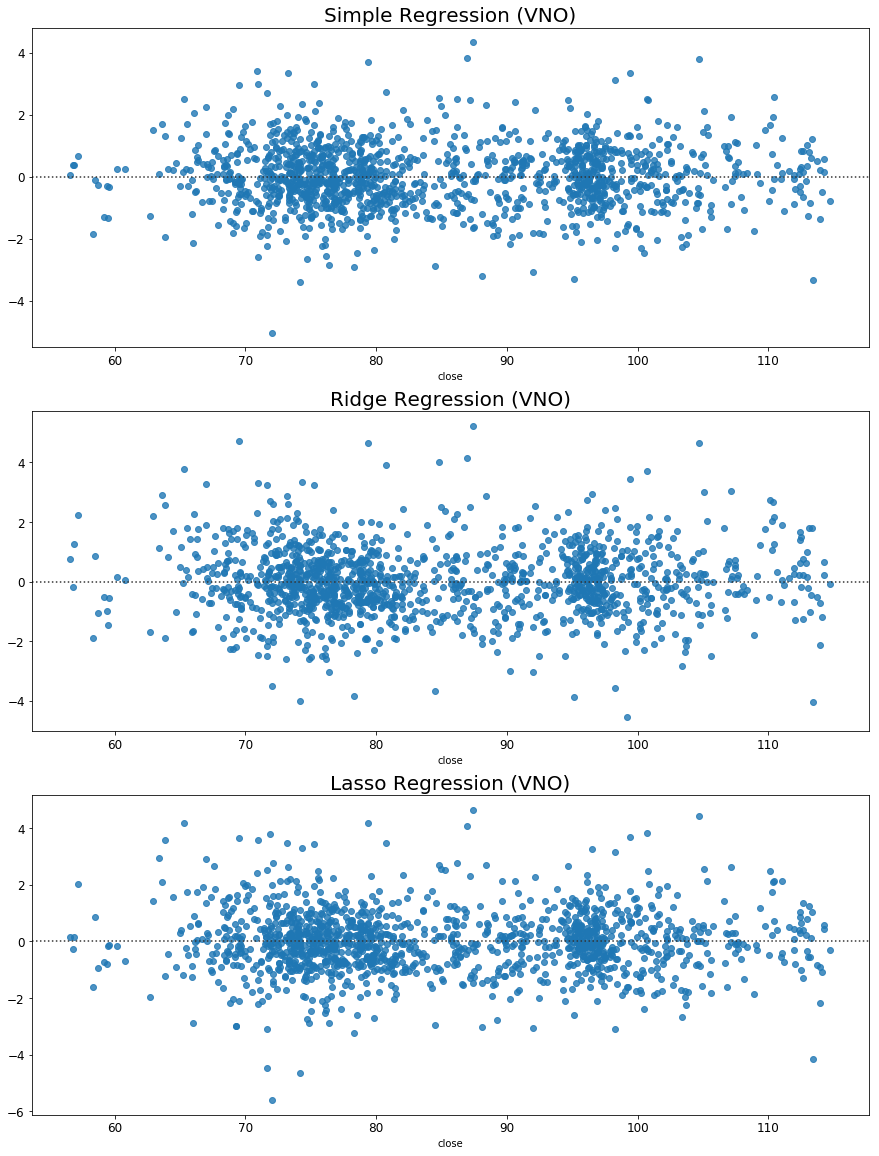

In [36]:
import seaborn

#Chosoe a sample size to plot
sample_size=train_data.shape[0];

#compute sample fraction so that we only have dat equal to sample size
sample_frac=sample_size/len(train_output);
sample=train_output.sample(frac=sample_frac,random_state=123);
sample_indexes=sample.index

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.figure(figsize=(15,20))


plt.subplot(311)
plt.title("Simple Regression ("+company+")",fontsize=20)
seaborn.residplot(train_output[sample_indexes],lr_train_prediction[sample_indexes])


plt.subplot(312)
plt.title("Ridge Regression ("+company+")",fontsize=20)
seaborn.residplot(train_output[sample_indexes],ridge_train_prediction[sample_indexes])


plt.subplot(313)
plt.title("Lasso Regression ("+company+")",fontsize=20)
seaborn.residplot(train_output[sample_indexes],lasso_train_prediction[sample_indexes])


#### Residual plot on test dataset

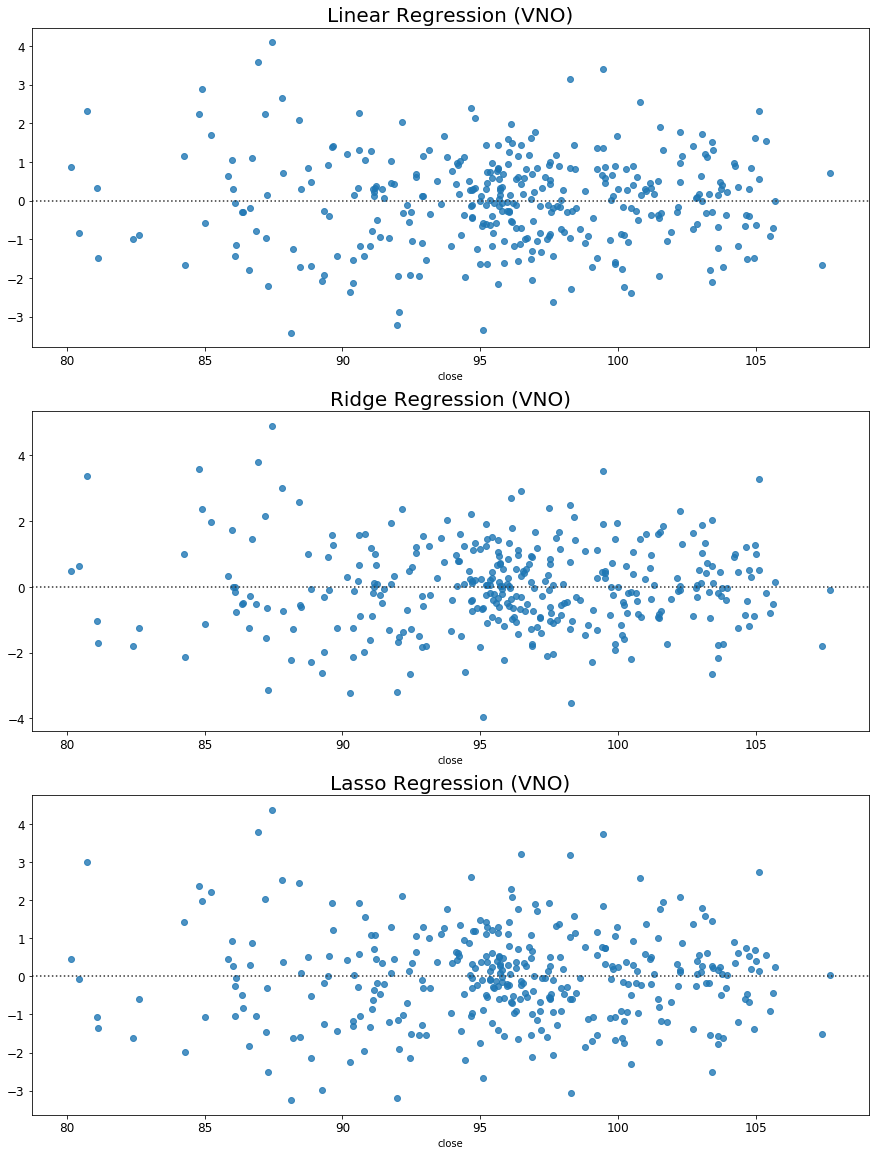

In [93]:
#Chosoe a sample size to plot
sample_size=test_data.shape[0];

#compute sample fraction so that we only have dat equal to sample size
sample_frac=sample_size/len(test_output);
sample=test_output.sample(frac=sample_frac,random_state=123);
sample_indexes=sample.index

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.figure(figsize=(15,20))

plt.subplot(311)
plt.title("Linear Regression ("+company+")",fontsize=20)
seaborn.residplot(test_output[sample_indexes],lr_test_prediction[sample_indexes])

plt.subplot(312)
plt.title("Ridge Regression ("+company+")",fontsize=20)
seaborn.residplot(test_output[sample_indexes],ridge_test_prediction[sample_indexes])

plt.subplot(313)
plt.title("Lasso Regression ("+company+")",fontsize=20)
seaborn.residplot(test_output[sample_indexes],lasso_test_prediction[sample_indexes])

#### See some prediction on train for all the models

In [94]:
actual_train=pd.DataFrame({"Actual":train_output})
lr_train=pd.DataFrame({"Regression":lr_train_prediction})
ridge_train=pd.DataFrame({"Ridge":ridge_train_prediction})
lasso_train=pd.DataFrame({"Lasso":lasso_train_prediction})
#pd.DataFrame([test_output, lr_test_prediction])

train_comparisons=pd.concat([actual_train,lr_train,ridge_train,lasso_train],axis=1)
train_comparisons.head(10)

,Actual,Regression,Ridge,Lasso
0,67.038046,67.551865,67.357764,68.010201
1,78.043478,79.811365,79.152568,79.390879
2,97.427526,96.819571,96.843008,96.447071
3,76.349638,76.214169,76.151999,76.488248
4,77.817030,77.163558,77.496214,77.254910
5,82.101446,81.537495,81.774690,82.104001
6,91.059774,91.268295,91.034998,90.836251
7,100.699997,101.135891,99.994160,100.152520
8,76.548910,75.658330,75.777746,75.798168
9,81.929350,81.592821,81.464189,81.622252


#### See some prediction on test for all the models

In [43]:
test_comparisons.head(10)

,Actual,Regression,Ridge,Lasso
0,96.940002,97.103991,96.794549,96.509174
1,104.750000,104.033589,103.107545,103.119896
2,103.830002,101.830795,101.692272,101.312430
3,101.919998,100.895178,101.222325,100.466061
4,101.000000,101.109230,100.968753,100.867407
5,101.449997,100.870277,100.219241,100.106370
6,100.650002,100.196567,100.190876,99.779475
7,100.300003,100.933669,100.678983,100.011534
8,100.540001,101.257724,101.349054,100.768053
9,101.330002,101.299023,101.104521,100.638688
